<a href="https://colab.research.google.com/github/gmprovan/CS4705/blob/main/CS4705_assignment_1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this assignment is to provide a means to use the tools introduced in class.
We will thus perform data preprocessing and compare decision tree and probabilistic classifiers. I provide you with helper code at the end of the assignment description. The marking for each question is shown.



Data: Census income data set

https://www.kaggle.com/uciml/adult-census-income

1. 30%: Run the following data imputation methods:

  -Mean Imputation
  
  -Cold Deck Imputation
  
  -Regression Imputation

2.  10%: Split the data into training and test subsets (80/20 split)

3. 30%: Compare the predictive accuracy of following classifiers; use standard statistical testing, e.g., p-tests, etc.

  -Decision Tree
  
  -Decision forest
  
  -naive Bayes (multinomial and Gaussian)
  
  -Regression

4. 30%: Comment on the "quality" of the different imputation methods and on the predictive accuracy of the classifiers; use standard statistical testing, e.g., p-tests, etc.




#IMPUTATION METHODS

**Mean Imputation**

Replace the missing value of the observation with a randomly selected value from all the observations in the sample that has similar values on other variables.

Thus, this technique ensures that the imputing value is only selected from the possible interval where the actual value could probably fall, and is randomly selected rather than being determined, which is an essential aspect for a correct standard error.

**Randomized Imputation**

Replace the missing data using a value chosen randomly.

**Hot Deck Imputation**

Replace the missing data using a value chosen from other variables with similar observation values in this technique.

**Regression Imputation**

Regression imputation involves fitting a regression model on a feature with missing data and then using this regression model’s predictions to replace the missing values in this feature. This technique preserves the relationships between features, and this grants it a significant advantage over simple imputation techniques such as mean and mode imputation.

Regression imputation can be defined into two categories:
Deterministic regression imputation

a) Deterministic regression imputation:

imputes the missing data with the exact value predicted from the regression model. This technique doesn’t consider the random variation around the regression line. Since the imputed values are exact, the correlation between the features and the dependent variables is overestimated.


b) Stochastic regression imputation

In stochastic regression imputation, we add a random variation (error term) to the predicted value, therefore, reproducing the correlation of X and Y more appropriately.

HELPER CODE IS SHOWN BELOW

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
#download the data and then load it
org_data = pd.read_csv('adult.csv', header=0)
org_data.shape

(32561, 15)

In [4]:
org_data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Pre-process the data; visualise the data
replace `?` with nan

In [5]:
org_data[org_data == "?"] = np.nan

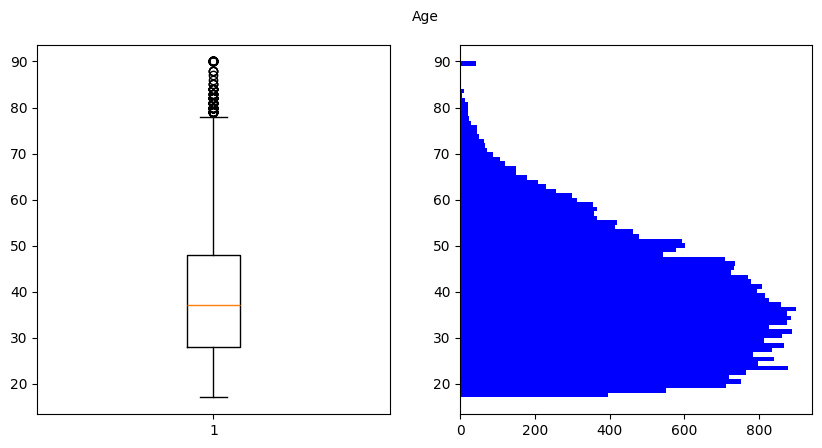

In [6]:
p, ax = plt.subplots(1, 2)

p.text(0.5, 0.93, "Age")
ax[0].boxplot(org_data["age"])
ax[1].hist(org_data["age"], bins=74, orientation='horizontal', color="blue")

p.set_figwidth(10)

We observe extrange behaviour at age = `90`, I assume this is because the data classifies people above `90` years old as `90`, at this point I am not very sure about what to do with this, so I am going to keep it, but if later I observe any problems I might have to change the values or delete them  depending on the model that is used.

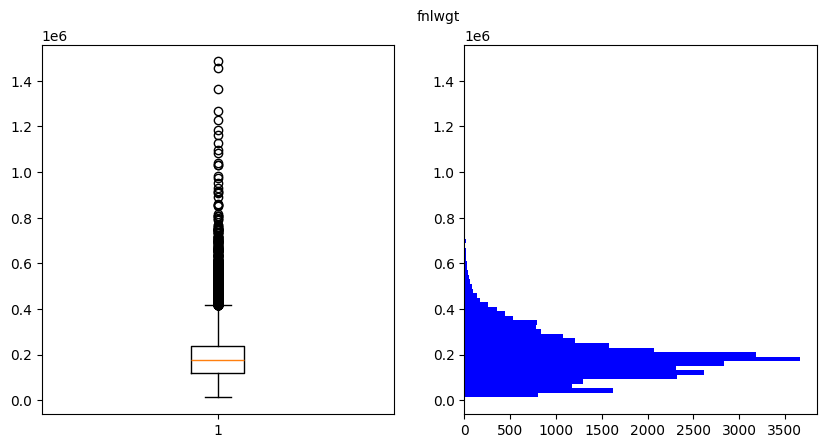

In [10]:
p, ax = plt.subplots(1, 2)

p.text(0.5, 0.93, "fnlwgt")
ax[0].boxplot(org_data["fnlwgt"])
ax[1].hist(org_data["fnlwgt"], bins=74, orientation='horizontal', color="blue")

p.set_figwidth(10)

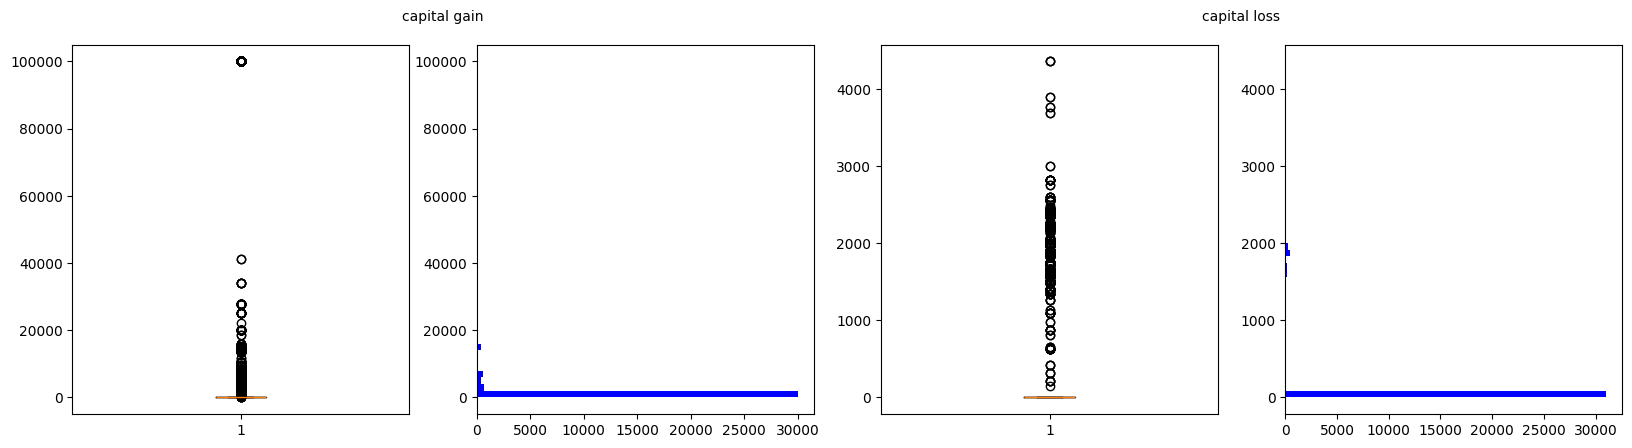

In [52]:
p, ax = plt.subplots(1, 4)

p.text(0.29, 0.93, "capital gain")
ax[0].boxplot(org_data["capital.gain"])
ax[1].hist(org_data["capital.gain"], bins=50, orientation='horizontal', color="blue")

p.text(0.69, 0.93, "capital loss")
ax[2].boxplot(org_data["capital.loss"])
ax[3].hist(org_data["capital.loss"], bins=50, orientation='horizontal', color="blue")

p.set_figwidth(20)

We do seem to have some outliers in the capital data, but this is probably important to the data and does not correspond to any values not imputed correctly.

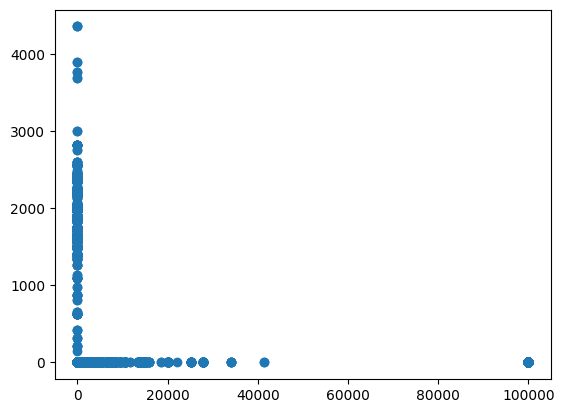

0

In [39]:
plt.scatter(org_data["capital.gain"], org_data["capital.loss"])
plt.show()
# Check none has both capital.gain and capital.loss
org_data[(org_data["capital.gain"] != 0) & (org_data["capital.loss"] != 0)].size
# Check that there are no null values
org_data["capital.gain"].isna().sum(), org_data["capital.loss"].isna().sum()

Since these represent the opposite thing, which means that nobody that has `capital.gain` also has `capital.loss` and vice-versa, I combine them into a single classifier `capital.change`

In [61]:
org_data["capital.change"] = org_data["capital.gain"] - org_data["capital.loss"]
org_data = org_data.drop(columns=["capital.loss", "capital.gain"])

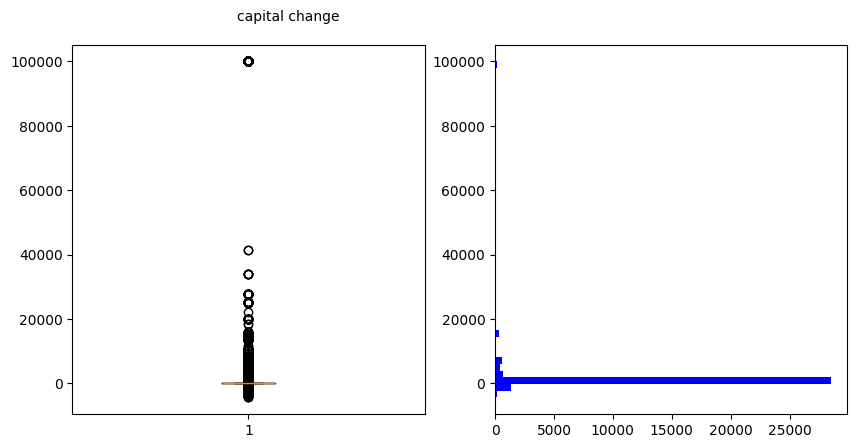

In [65]:
p, ax = plt.subplots(1, 2)

p.text(0.29, 0.93, "capital change")
ax[0].boxplot(org_data["capital.change"])
ax[1].hist(org_data["capital.change"], bins=50, orientation='horizontal', color="blue")
p.set_figwidth(10)
plt.show()

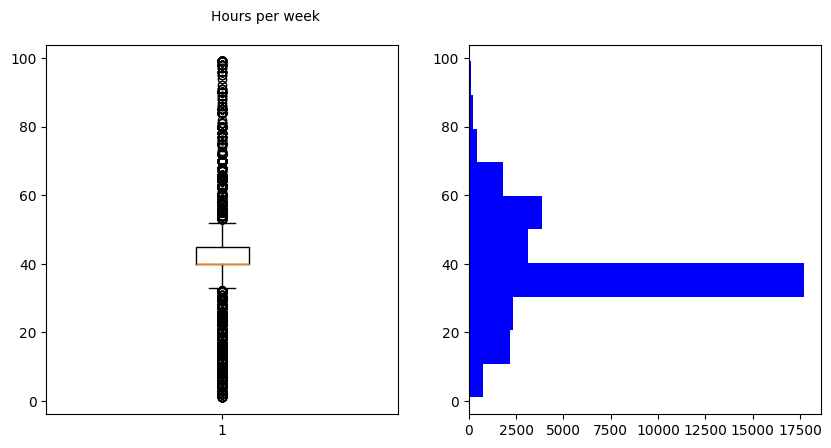

In [67]:
p, ax = plt.subplots(1, 2)

p.text(0.29, 0.93, "Hours per week")
ax[0].boxplot(org_data["hours.per.week"])
ax[1].hist(org_data["hours.per.week"], bins=10, orientation='horizontal', color="blue")
p.set_figwidth(10)
plt.show()

This figure shows a normal-like distribution but the value 40 is obviously more present for some reason

In [ ]:
fig, axe = plt.subplots(5, 3)
arr = [[i, j] for i in range(5) for j in range(3)]
print(arr)
count = 0
for i in org_data.select_dtypes("object"):
    org_data[i].value_counts(dropna=False).plot(kind="bar", ax=axe[*arr[count]], figsize=(30, 70))
    count += 1
for i in org_data.select_dtypes("number"):
    org_data[i].hist(ax=axe[*arr[count]], figsize=(30, 80), bins= 70)
    axe[*arr[count]].set_xlabel(i)
    count += 1

<Axes: xlabel='education.num'>

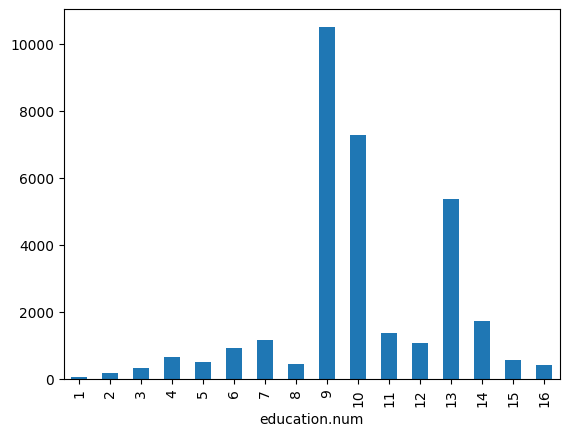

In [101]:
org_data["education.num"].value_counts(dropna=False).sort_index().plot.bar()

Imputation phase

In [34]:
org_data.isna().sum(axis=0)

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [25]:
# Importing the class called SimpleImputer from impute model in sklearn
from sklearn.impute import SimpleImputer
# To replace the missing value we create below object of SimpleImputer class
imputa = SimpleImputer(missing_values = np.nan, strategy = 'mean')
''' Using the fit method, we apply the `imputa` object on the matrix of our feature x.
The `fit()` method identifies the missing values and computes the mean of such feature a missing value is present.
'''
imputa.fit(org_data)
# Repalcing the missing value using transform method
#x[:, 1:3] = imputa.transform(x[:, 1:3])

imputa

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'Private'

split data into train and test

In [ ]:
#split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state= 1)



scaling of features

In [ ]:
#feature scaling

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# we only aply the feature scaling on the features other than dummy variables.
x_train[:, 3:] = sc.fit_transform(x_train[:, 3:])
x_test[:, 3:] = sc.fit_transform(x_test[:, 3:])



Train classifiers

In [ ]:
#classifiers: naive Bayes as an example

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb.fit(X_train, Y_train)

Y_pred_nb = nb.predict(X_test)

Provide statistical tests to compare the classifiers and the impact of imputation types